In [1]:
from rasterio import transform
from rasterio.enums import ColorInterp, Resampling
from rasterio.io import MemoryFile
from rasterio.plot import reshape_as_image, reshape_as_raster
from rasterio.vrt import WarpedVRT
import fiona
import distancerasters as dr
import rasterio
from affine import Affine

In [2]:
pixel_size = 0.1
max_distance = 60000
shp = fiona.open("../../data/aux_datasets/infra_locations.json")
xmin = -180
xmax = 180
ymin = -80
ymax = 80

In [3]:
affine = Affine(pixel_size, 0, xmin,
                0, -pixel_size, ymax)
shape = (int((ymax-ymin)/pixel_size), int((xmax-xmin)/pixel_size))
rv_array, affine = dr.rasterize(
    shp,
    affine=affine,
    shape=shape,
)

In [4]:
rv_array.shape

(1600, 3600)

In [5]:
my_dr = dr.DistanceRaster(
            rv_array,
            affine=affine,
        )
dist_array = my_dr.dist_array

# array values to match 0 - 255 where 255 is furthest away from feature
dist_array = dist_array / (max_distance / 255)  # 60 km
dist_array[dist_array >= 255] = 255

Tree build time: 0.0514 seconds
Distance calc run time: 210.6555 seconds


In [6]:
dist_array.shape

(1600, 3600)

In [7]:
import skimage.io as skio

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


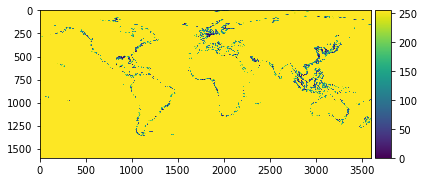

In [8]:
skio.imshow(dist_array)

In [10]:
my_dr.output_raster("../../data/aux_datasets/infra_locations_01.tiff")

In [80]:
from rasterio.io import MemoryFile
bounds = (55, 24, 59, 27)
with COGReader("../../data/aux_datasets/infra_locations_01_cogeo.tiff") as image:
        img = image.part(bounds)
        with MemoryFile(img.render(img_format="gtiff")) as mem:
            with mem.open() as s:
                print(s.meta)
                prof = s.meta
                prof["count"] = 1
                with rasterio.open("./test_cogeo.tiff", "w", **prof) as dst:
                    dst.write(img.data)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 40, 'height': 30, 'count': 2, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.1, 0.0, 55.0,
       0.0, -0.1, 27.0)}


In [66]:
from rio_tiler.io import COGReader
import skimage
import numpy as np

In [67]:
bounds = (55.698181, 24.565813, 58.540211, 26.494711)
img_shape = (4181, 6458)
with COGReader("../../data/aux_datasets/infra_locations_01_cogeo.tiff") as image:
        img = image.part(bounds)
        data = img.data_as_image()
data = data / (max_distance / 255)  # 60 km
data[data >= 255] = 255
upsampled = skimage.transform.resize(data, (*img_shape[0:2],1), preserve_range=True).astype(np.uint8)
upsampled = np.squeeze(upsampled)



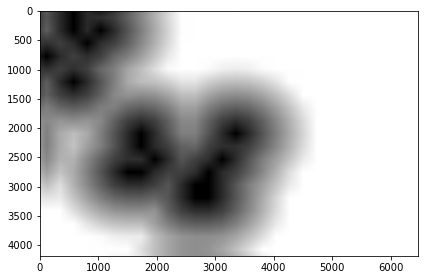

In [68]:
skio.imshow(upsampled.astype(np.uint8))

In [69]:
upsampled.shape

(4181, 6458)

In [70]:
np.max(upsampled)

255

In [ ]:
# Make cogeo
!rio cogeo create data/aux_datasets/infra_locations_01.tiff data/aux_datasets/infra_locations_01_cogeo.tiff